In [1]:
%run preprocess.py

Reading and Labelling: 100%|█████████████████████████████████████████████████████████| 234/234 [03:40<00:00,  1.06it/s]

Preprocessing data finished! 



In [2]:
import joblib
joblib.cpu_count()

32

In [3]:
import torch
print(torch.cuda.device_count())

1


In [4]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path 

In [5]:
metadata_dir='metadata'
processed_dir='processed data'



In [6]:
metadata_dir=Path(metadata_dir)
processed_dir=Path(processed_dir)
traincsv_dir=metadata_dir/"train_set.csv"
train_meta=pd.read_csv(traincsv_dir)
meta_csvdir=metadata_dir/'metadata.csv'
metadata=pd.read_csv(meta_csvdir)

In [7]:
patient_pat=metadata.loc[0]["filepath"].split('\\')[-1]
print(patient_pat)

N185326362.pt


count how many normal/ abnormal in the dataset

In [8]:
total_normal=[]
total_abnormal=[]
for i in range(len(metadata["filepath"])):
    patient_pat=metadata.loc[i]["filepath"].split('\\')
    patient=patient_pat[-1]
    patient='processed data\\'+patient

    data=torch.load(patient)

    if data["label"]==1:
        total_abnormal.append(patient)
    else:
        total_normal.append(patient)
     
        
    

                                                    
                                                    

In [1]:
print(len(total_normal))
print(len(total_abnormal))

NameError: name 'total_normal' is not defined

In [10]:
print(len(total_normal)/len(total_abnormal))

2.9


In [11]:
%run augmentation.py



In [12]:
train_meta=pd.read_csv(traincsv_dir)

train_normal=[]
train_abnormal=[]

for i in range(len(train_meta["filepath"])):
    patient_pat=train_meta.loc[i]["filepath"].split('\\')
    patient=patient_pat[-1]
    data=torch.load('processed data\\'+patient)

    if data["label"]==1:
        train_abnormal.append(patient)
    else:
        train_normal.append(patient)

print(len(train_normal))
print(len(train_abnormal))

102
114


In [7]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs


In [6]:
# %reload_ext tensorboard
%tensorboard --logdir=runs --host localhost


UsageError: Line magic function `%tensorboard` not found.


In [28]:
!taskkill /im tensorboard.exe /f
del /q %TMP%\.tensorboard-info\*

SyntaxError: invalid syntax (2877679443.py, line 2)

{'checkpoint_dir': 'checkpoints/checkpoints_FFC_res18', 'checkpoint_name': 'model.ckpt-10000.pt', 'dataset_dir': '../../../metadata', 'type': 'FFC_res18'}
..\..\..\metadata\test_set.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.03it/s]

MPI test:
{'average_acc': 0.8461538461538461, 'average_precision': 0.4993894993894994, 'recall': 0.5555555555555556, 'auc': 0.7444444444444445, 'confusion_matrix': array([[28,  2],
       [ 4,  5]], dtype=int64)}
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.71      0.56      0.63         9

    accuracy                           0.85        39
   macro avg       0.79      0.74      0.76        39
weighted avg       0.84      0.85      0.84        39



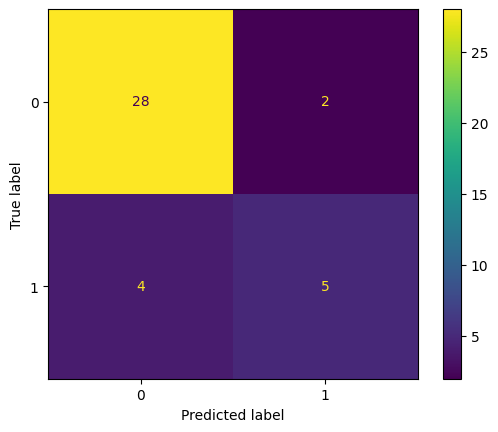

In [39]:
%run test_single.py


In [1]:

from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils import MPIDataset,save_checkpoint, load_checkpoint,Evaluator
from models.Classifiers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model=FFC_res18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir=Path(r"checkpoints/checkpoints_FFC_res18")/"model.ckpt-10000.pt"
checkpoint=torch.load(checkpoint_dir)
model.load_state_dict(checkpoint["model"])  
model.to(device)
model.eval()


MPI_testset=MPIDataset(Path("metadata")/'test_cam.csv')
MPI_dataloader=DataLoader(
    MPI_testset,
    batch_size=64,
    shuffle=False,
    drop_last=False
)
        
    

In [4]:

dataiter=iter(MPI_dataloader)
data=next(dataiter)

for i in range(len(MPI_testset)):
    if torch.eq(data["label"][i].to(device),1):
        with torch.no_grad():
            mpi=data["image"][i].unsqueeze(0).to(device)
            print(i)
            out=torch.nn.functional.sigmoid(model(mpi))
            print(out)

    else : continue
    


2
tensor([[0.0206]], device='cuda:0')
8
tensor([[0.9551]], device='cuda:0')
9
tensor([[2.3226e-07]], device='cuda:0')
10
tensor([[0.8819]], device='cuda:0')
20
tensor([[0.0171]], device='cuda:0')
23
tensor([[0.9997]], device='cuda:0')
24
tensor([[0.9999]], device='cuda:0')
28
tensor([[0.9998]], device='cuda:0')
30
tensor([[1.3561e-05]], device='cuda:0')


In [16]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
class GradCAM_(GradCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        return grads

In [23]:





### hook on avgpool!!!   it's tuple (x,0) after layer4,   or write a transform function
target_layers=[model.model.avgpool]
# target_layers=[model.model.layer4]
input_tensor=data['image'][23].unsqueeze(0).to(device)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets=[BinaryClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

##(1, 512, 1, 1)
# print(grayscale_cam.shape)
# print(grayscale_cam.squeeze().shape)
# print(np.squeeze(grayscale_cam,axis=0))
# plt.figure()
# # plt.imshow(grayscale_cam[0,:])
# plt.colorbar()

tensor([[[[1.5784]],

         [[1.8085]],

         [[0.3257]],

         [[0.1097]],

         [[0.1931]],

         [[1.4597]],

         [[0.2395]],

         [[0.2283]],

         [[0.1248]],

         [[0.1422]],

         [[0.1604]],

         [[0.1862]],

         [[0.1534]],

         [[0.3542]],

         [[0.1752]],

         [[2.9027]],

         [[2.6339]],

         [[2.7813]],

         [[2.6704]],

         [[0.2029]],

         [[1.8808]],

         [[0.1021]],

         [[2.4967]],

         [[0.1142]],

         [[0.3850]],

         [[2.5425]],

         [[1.6166]],

         [[0.2039]],

         [[0.2503]],

         [[3.0614]],

         [[3.0700]],

         [[0.3760]],

         [[0.1424]],

         [[2.9450]],

         [[2.2758]],

         [[0.2043]],

         [[0.3479]],

         [[0.1179]],

         [[0.2139]],

         [[0.2321]],

         [[0.1070]],

         [[0.2282]],

         [[2.7164]],

         [[2.9349]],

         [[2.9465]],

         [

In [27]:
target_layers=[model.model.layer4[-1]]
# target_layers=[model.model.layer4]
input_tensor=data['image'][23].unsqueeze(0).to(device)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets=[BinaryClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)



(tensor([[[[1.0673, 1.5232, 1.6745,  ..., 1.2309, 1.0510, 0.7316],
          [1.5212, 2.6046, 2.7841,  ..., 2.3073, 1.9133, 0.9317],
          [2.1289, 2.3252, 2.9878,  ..., 3.3745, 3.2575, 1.0350],
          ...,
          [1.2466, 1.8353, 2.6468,  ..., 2.1743, 2.6406, 1.0694],
          [1.0244, 1.3853, 1.5738,  ..., 1.4231, 1.4597, 0.9863],
          [0.6307, 0.8020, 0.7642,  ..., 0.9066, 0.8160, 0.6168]],

         [[1.4962, 1.3114, 2.4430,  ..., 1.9423, 1.4127, 0.8106],
          [1.5064, 3.2966, 3.9181,  ..., 2.1270, 1.3749, 1.1978],
          [1.5600, 3.7332, 4.8115,  ..., 3.3420, 1.8626, 1.4359],
          ...,
          [1.7994, 2.4683, 2.1365,  ..., 3.2343, 2.6170, 2.9455],
          [2.4636, 2.9197, 1.8580,  ..., 2.9490, 1.6964, 2.4339],
          [1.1967, 1.5096, 1.2778,  ..., 1.8087, 0.8726, 0.6054]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 

AttributeError: 'tuple' object has no attribute 'cpu'

In [33]:
model_t = Res18()
target_layers = [model_t.model.layer4[-1]]
input_tensor = data['image'][23].unsqueeze(0).to(device)

cam = GradCAM(model=model_t, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets=[BinaryClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)


tensor([[[[0.2754, 0.0000]],

         [[0.0790, 0.0000]],

         [[0.0000, 0.0000]],

         ...,

         [[0.1274, 0.7816]],

         [[0.1895, 0.5236]],

         [[0.1025, 0.0000]]]], device='cuda:0', grad_fn=<ReluBackward0>)


In [34]:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)
print(grayscale_cam)

(15, 36)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.02777777 0.08333332 0.13888887
  0.19444442 0.24999996 0.3055555  0.36111104 0.4166666  0.47222215
  0.52777773 0.58333325 0.63888884 0.69444436 0.74999994 0.8055555
  0.86111104 0.9166666  0.9722221  0.9999998  0.9999998  0.9999998
  0.9999998  0.9999998  0.9999998  0.9999998  0.9999998  0.9999998 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.02777777 0.08333332 0.13888887
  0.19444442 0.24999996 0.3055555  0.36111104 0.4166666  0.47222215
  0.52777773 0.58333325 0.63888884 0.69444436 0.74999994 0.8055555
  0.86111104 0.9166667  0.97222215 0.9999998  0.9999998  0.9999998
  0.9999998  0.9999998  0.9999998  0.9999998  0.9999998  0.9999998 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.02777777 0.08333332 0.13888887
  0.19444442 0.24999996 0.3055555  0.36111104 0.4166666  0.472222

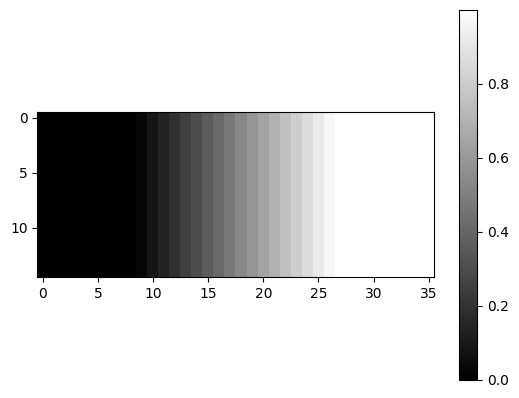

In [37]:
plt.imshow(grayscale_cam,cmap='gray')
plt.colorbar()